In [1]:
import torch, detectron2

from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import  get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.visualizer import ColorMode, Visualizer
from detectron2 import model_zoo
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.data.detection_utils import read_image
import detectron2.data.transforms as T


import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

import data_loaders

import os

# Directorio donde se encuentran las imágenes originales
directorio = '../frames'

# Itera sobre todas las imágenes en el directorio
for i, nombre_archivo in enumerate(os.listdir(directorio)):
    # Construye el nuevo nombre de archivo con el formato deseado
    nuevo_nombre = f"{i:05d}.jpg"
    # Renombra el archivo
    os.rename(os.path.join(directorio, nombre_archivo), os.path.join(directorio, nuevo_nombre))

print("Renombrado completado.")

In [2]:
class Detector:
    
    def __init__(self, model_type = "OD", outpath:str="./random"):
        self.cfg = get_cfg()
        
        #Load model config and pretrained model
        if model_type == "OD":
            self.cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
            self.cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")      
            
            
        elif model_type == "IS":
            
            self.cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
            self.cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")      
            
        elif model_type == "KP":
            
            self.cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
            self.cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")      
            
                
        self.cfg.OUTPUT_DIR =   os.path.join(outpath, "faster")      
        self.cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
        self.cfg.MODEL.DEVICE = "cuda"
        self.cfg.SOLVER.IMS_PER_BATCH = 4
        self.cfg.SOLVER.CHECKPOINT_PERIOD = 250
        self.cfg.SOLVER.MAX_ITER = 1500

        self.__loader_mapping = loader_mapping = {
                                                'first': data_loaders.load_sequential_hold_out,
                                                'random': data_loaders.load_random_data,
                                                '13': data_loaders.load_13,
                                                '12': data_loaders.load_12,
                                                '23': data_loaders.load_23
                                            }
        
        self._datasets = {"train": None, "val": None}
        self._metadata = { "train": None, "val": None }


    def prepare_dataset(self, kind:str = "first", kfolds:bool=False, select_folds:str="12"):
        self.loader = self.__loader_mapping.get(kind if not kfolds else select_folds, None)

        if self.loader is None:
            raise ValueError("Invalid split or folds value")

        for data_type in ['train', 'val']:
            dataset_name = f"{data_type}_{kind if not kfolds else select_folds}"
            DatasetCatalog.register(dataset_name, lambda d=data_type: self.loader(d))
            MetadataCatalog.get(dataset_name)#.set(thing_classes=["car", "bike"])

        self._metadata["train"] = MetadataCatalog.get(f"train_{kind if not kfolds else select_folds}")
        self._metadata["val"] = MetadataCatalog.get(f"val_{kind if not kfolds else select_folds}")


        self._datasets["train"] = DatasetCatalog.get(f"train_{kind if not kfolds else select_folds}")
        self._datasets["val"] = DatasetCatalog.get(f"val_{kind if not kfolds else select_folds}")


        self.cfg.DATASETS.TRAIN = (f"train_{kind if not kfolds else select_folds}",)
        self.cfg.DATASETS.TEST = (f"val_{kind if not kfolds else select_folds}",)
        os.makedirs(self.cfg.OUTPUT_DIR, exist_ok=True)

    def fit_(self):
        trainer = DefaultTrainer(self.cfg)
        trainer.resume_or_load(resume=False)

        trainer.train()
        

     

In [3]:
detector = Detector(model_type="OD", outpath="./sequential")

In [4]:
detector.prepare_dataset("first")

In [16]:
detector.fit_()

[03/05 09:59:15 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [18]:
!pwd

/home/cboned/Desktop/Master/mcv-c6-2024-team6/W2/part1


In [19]:
import yaml
# Save the configuration to a config.yaml file
# Save the configuration to a config.yaml file
config_yaml_path = "configs/config_faster_first.yaml"
with open(config_yaml_path, 'w') as file:
    yaml.dump(detector.cfg, file)
     

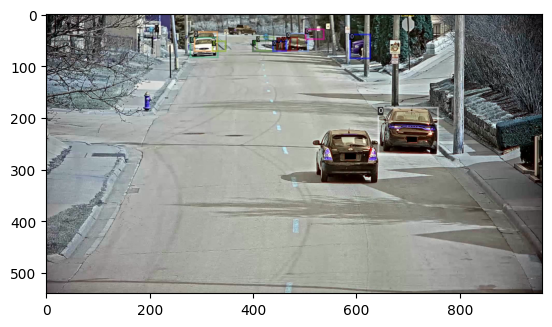

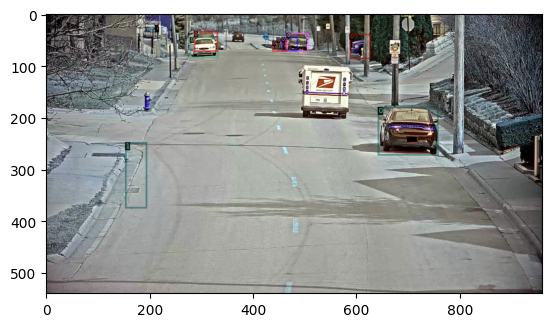

In [5]:
import random

# Visualize some random samples
for d in random.sample(detector._datasets["train"], 2):
    img = cv2.imread(d["file_name"])
    
    visualizer = Visualizer(img[:, :, ::-1], metadata=detector._metadata["train"], scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

In [41]:
detector._metadata["train"]

namespace(name='train_first', thing_classes=['car', 'bike'])

In [43]:
detector._datasets["train"]

[{'id': 1,
  'license': 1,
  'file_name': 'frames/00001.jpg',
  'height': 1080,
  'width': 1920,
  'date_captured': None,
  'image_id': 1,
  'annotations': [{'id': 4707,
    'image_id': 1,
    'category_id': 0,
    'bbox': [558.36, 94.45, 105.13, 74.86],
    'segmentation': [],
    'keypoints': [],
    'num_keypoints': 0,
    'score': 1,
    'area': 7870.0318,
    'iscrowd': 0,
    'bbox_mode': 1},
   {'id': 6848,
    'image_id': 1,
    'category_id': 0,
    'bbox': [573.7, 72.89, 87.70999999999992, 72.16000000000001],
    'segmentation': [],
    'keypoints': [],
    'num_keypoints': 0,
    'score': 1,
    'area': 6329.153599999995,
    'iscrowd': 0,
    'bbox_mode': 1},
   {'id': 8989,
    'image_id': 1,
    'category_id': 0,
    'bbox': [913.24, 93.02, 58.89999999999998, 51.55],
    'segmentation': [],
    'keypoints': [],
    'num_keypoints': 0,
    'score': 1,
    'area': 3036.2949999999987,
    'iscrowd': 0,
    'bbox_mode': 1},
   {'id': 11130,
    'image_id': 1,
    'category_id

Instances(num_instances=19, image_height=1080, image_width=1920, fields=[pred_boxes: Boxes(tensor([[ 105.7509,  368.2905,  182.5142,  525.4202],
        [ 819.0295,  285.5691,  897.5773,  459.5700],
        [ 560.3142,   93.0656,  659.1874,  169.4607],
        [1287.7123,  360.5521, 1514.2369,  541.2962],
        [ 127.2015,  473.3490,  157.2923,  554.3177],
        [1178.4170,  101.1859, 1228.7111,  158.2191],
        [1373.1885,   13.6736, 1424.5464,   73.9917],
        [ 787.8288,   73.6340,  869.8632,  139.3279],
        [ 912.3279,   95.8796,  944.2032,  140.5934],
        [ 588.5972,   72.9185,  655.5634,  114.9508],
        [ 611.2476,  447.8857,  976.3563,  775.0246],
        [ 928.7946,   84.6795, 1011.1038,  145.1875],
        [ 892.0041,   94.1555,  939.4225,  140.2658],
        [ 612.3903,  452.3955,  975.7444,  772.0178],
        [ 417.5084,   43.8730,  435.9140,   76.5780],
        [ 376.7248,  302.4214,  405.6948,  376.8658],
        [ 875.7081,   97.7519,  916.5692,  14

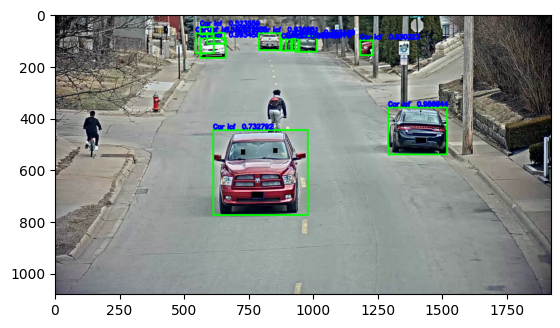

In [51]:
import random
from detectron2.utils.visualizer import ColorMode
predictor = DefaultPredictor(detector.cfg)
for d in (detector._datasets["train"]):    #select number of images for display
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    imagen_con_bboxes = im.copy()
    print(outputs["instances"])
    for ii, bbox in  enumerate(outputs["instances"].pred_boxes):
        x_min, y_min, x_max, y_max = bbox.int().cpu().numpy()

        if outputs["instances"].pred_classes[ii] == 2:
            cv2.rectangle(imagen_con_bboxes, (x_min, y_min), (x_max, y_max), (0, 255, 0), 5)
            cv2.putText(imagen_con_bboxes, f"Car icf {outputs['instances'].scores[ii]: 2f}", (x_min, y_min - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 5)


    plt.imshow(imagen_con_bboxes[:, :, ::-1])
    plt.show()
    break
     


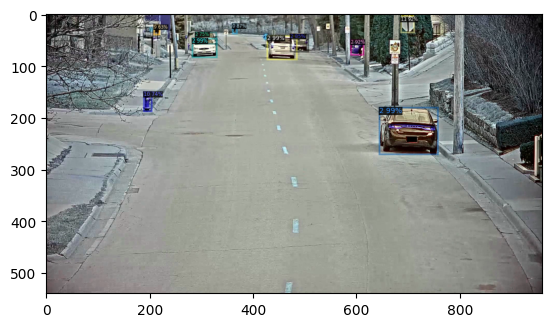

In [10]:
import random
from detectron2.utils.visualizer import ColorMode

predictor = DefaultPredictor(detector.cfg)
for d in random.sample(detector._datasets["train"], 1):    #select number of images for display
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=detector._metadata["train"],
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE    # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    instances = outputs["instances"]
    out = v.draw_instance_predictions(instances[instances.pred_class == 2].to("cpu"))
    plt.imshow(out.get_image()[:, :, ::-1])

In [ ]:
    v = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get(detector.cfg.DATASETS.TRAIN[0]),
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    print(outputs["instances"].pred_boxes)

    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))